In [1]:
%matplotlib inline
import glob
import numpy as np
import pandas as pd
# import rasterio as rio
# from rasterio.windows import Window
from osgeo import gdal
import matplotlib.pyplot as plt
import os
from scipy import optimize
from scipy import stats
import itertools
from mintpy.utils import network, plot

In [2]:
def norm_data(data):
    """
    normalize data to have mean=0 and standard_deviation=1
    """
    mean_data=np.mean(data)
    std_data=np.std(data, ddof=1)
    #return (data-mean_data)/(std_data*np.sqrt(data.size-1))
    return (data-mean_data)/(std_data)

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def ncc(data0, data1):
    """
    normalized cross-correlation coefficient between two data sets

    Parameters
    ----------
    data0, data1 :  numpy arrays of same size
    """
    return (1.0/(data0.size-1)) * np.sum(norm_data(data0)*norm_data(data1))


def nss(data0, data1):
    """
    normalized sum of square difference between two data sets

    Parameters
    ----------
    data0, data1 :  numpy arrays of same size
    """
    return np.sum((norm_data(data0)-norm_data(data1))**2) / np.sqrt(np.sum(data0**2) + np.sum(data1**2))

In [3]:
cd /mnt/i/sentinel2/yearly_pan_v2

/mnt/i/sentinel2/yearly_pan_v2


In [4]:
# b08dat = glob.glob('*B08_10m*.dat')
s2s = glob.glob('*tif')

names = {os.path.basename(x)[6:14]:x for x in s2s}
names

{'20160601': 's2_l2_20160601.tif',
 '20170601': 's2_l2_20170601.tif',
 '20180601': 's2_l2_20180601.tif',
 '20190601': 's2_l2_20190601.tif',
 '20200601': 's2_l2_20200601.tif',
 '20210601': 's2_l2_20210601.tif'}

In [6]:
data = {}
for d in names:
    ds = gdal.Open(names[d], gdal.GA_ReadOnly)
    arr = ds.GetRasterBand(1).ReadAsArray()
#     arr[np.isnan(arr)] = 0
    data[d] = arr
    ds = None

In [7]:
df_long = pd.DataFrame(columns=['date1','date2','ncc'])
for a,b in [sorted(x) for x in itertools.combinations(data.keys(),2)]:
    val = ncc(data[a],data[b])
    df_long = df_long.append({'date1':a,'date2':b,'ncc':val},ignore_index=True)

In [8]:
df = pd.DataFrame(index=data.keys(),columns=data.keys())
for a,b in itertools.permutations(data.keys(),2):
    val = ncc(data[a],data[b])
    df.loc[a,b] = val

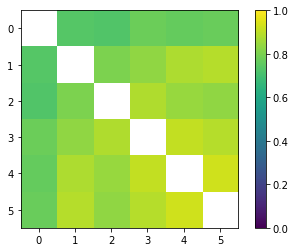

In [9]:
im = plt.imshow(df.astype(float).to_numpy())
plt.colorbar()
plt.clim(0,1)

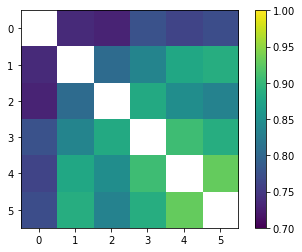

In [10]:
limit = 0.7
df_filt = df.copy()
df_filt[df_filt <= limit] = 0

plt.imshow(df_filt.astype(float).to_numpy())
plt.colorbar()
plt.clim(limit,1)

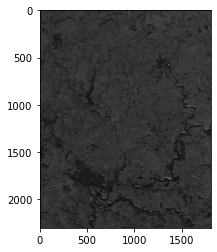

In [11]:
plt.imshow(data[df.index[1]],cmap='gray')

(6,)


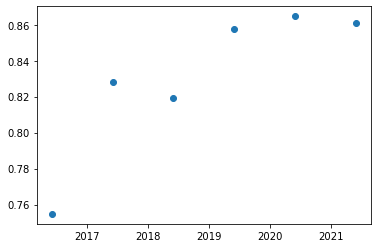

In [12]:
x = pd.to_datetime(df.index).to_numpy()
means = df.mean(axis=1)
y = means.to_numpy()
plt.scatter(x,y)
print(means.shape)
# plt.ylim(0.6,0.75)

In [13]:
exclude = list(means.index[means < 0.4])
exclude_date = pd.to_datetime(exclude)
print(exclude)

[]


<AxesSubplot:ylabel='Frequency'>

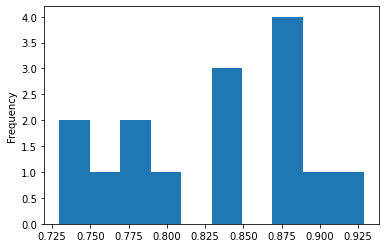

In [14]:
df_long.ncc.plot.hist()

In [15]:
ts = df_long.copy()
ts = ts[~ts.ncc.isnull()]

# add date12
ts['date12'] = ts['date1'] + '-' + ts['date2']

# remove problematic dates
ts = ts[(~ts['date1'].isin(exclude)) & (~ts['date2'].isin(exclude))]

# calculate date difference
ts['date1'] = pd.to_datetime(ts['date1'])
ts['date2'] = pd.to_datetime(ts['date2'])
ts['date_diff'] = (ts['date2'] - ts['date1']).dt.days

# calculate day of year
ts['doy1'] = ts.date1.dt.dayofyear
ts['doy2'] = ts.date2.dt.dayofyear

# remove <365 pairs
# ts = ts[ts.date_diff >= 365]

ts.shape

(15, 7)

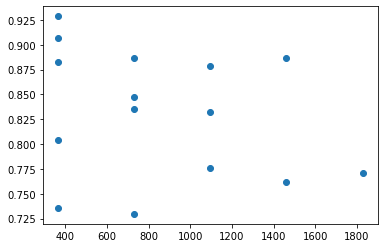

In [16]:
plt.scatter(ts['date_diff'],ts['ncc'])

The period of the best fit cos function is 365, with an rmse of 0.0540 and a r2 of 0.50


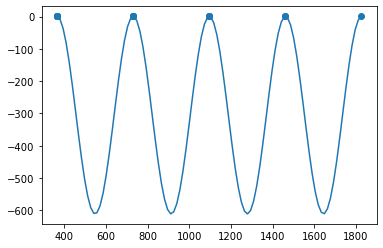

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

def curve(x,a,b,c):
    y = a * np.cos(b*x) + c
    return y

guess = [0.2, (2*np.pi)/365, ts['ncc'].mean()]
res_max, cov_max = optimize.curve_fit(curve, ts['date_diff'], ts['ncc'], p0=guess)

n = np.linspace(ts['date_diff'].min(), ts['date_diff'].max(), num=100)
reg = curve(n, *res_max)

plt.scatter(ts['date_diff'],ts['ncc'])
plt.plot(n,reg)

rmse_val = rmse(ts['ncc'],curve(ts['date_diff'], *res_max))
r2, _ = stats.pearsonr(ts['ncc'],curve(ts['date_diff'], *res_max))
period = (2*np.pi)/res_max[1]
print(f'The period of the best fit cos function is {period:.0f}, with an rmse of {rmse_val:.4f} and a r2 of {r2:.2f}')

## Time-Period Based Selection

selected 15 of 15, increasing avg ncc from 0.83 to 0.83


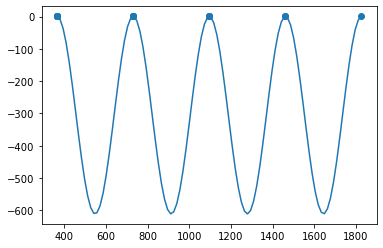

In [18]:
wrap = 365
width = 30
ts['distance'] = (ts['date_diff'] % wrap)
valid = ts[((ts.distance<=width) | (ts.distance>=wrap-width)) & (ts.date_diff<=wrap*10) & (ts.date_diff>=wrap/2)].copy()

plt.scatter(valid['date_diff'],valid['ncc'])
plt.plot(n,reg)

print(f'selected {valid.shape[0]} of {ts.shape[0]}, increasing avg ncc from {ts.ncc.mean():.2f} to {valid.ncc.mean():.2f}')

-0.013567300386699965 0.8626503525019814 0.2715283010831142


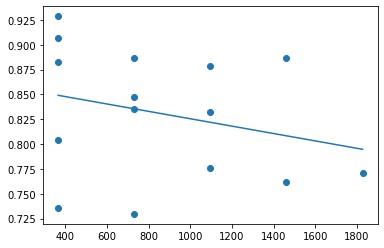

In [19]:
m,b = np.polyfit(valid['date_diff'],valid['ncc'],1)
reg_line = m*n+b

plt.scatter(valid['date_diff'],valid['ncc'])
plt.plot(n,reg_line)

print(m*365,b,stats.pearsonr(valid['ncc'],m*valid['date_diff']+b)[0])

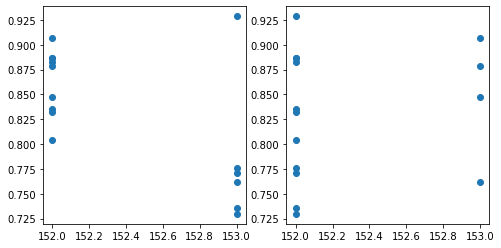

In [20]:
f, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4))
ax1.scatter(valid['doy1'],valid['ncc'])
ax2.scatter(valid['doy2'],valid['ncc'])

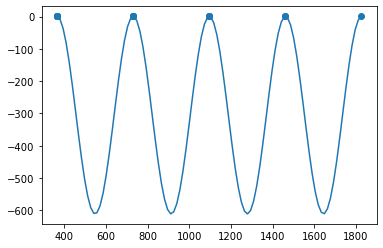

In [21]:
#get min spanning tree
mst = network.threshold_coherence_based_mst(list(ts.date12),list(ts.ncc))
mst = ['20'+x[:7]+'20'+x[7:] for x in mst]

date12_list = list(set(valid.date12) | set(mst))
pairs = ts[ts.date12.isin(date12_list)].copy().reset_index(drop=True)
pairs.sort_values(['date1','date2'],inplace=True)

pairs['image1'] = [names[x] for x in pairs.date1.dt.strftime('%Y%m%d')]
pairs['image2'] = [names[x] for x in pairs.date2.dt.strftime('%Y%m%d')]
# pairs[['image1','image2']].to_csv('pairs.csv',index=False)

plt.scatter(pairs.date_diff,pairs.ncc)
plt.plot(n,reg)

## Threshold based selection

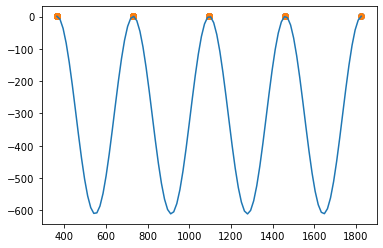

In [22]:
#get min spanning tree
ds = ts[ts.date_diff >= 365/2].copy()
mst = network.threshold_coherence_based_mst(list(ds.date12),list(ds.ncc))
mst = ['20'+x[:7]+'20'+x[7:] for x in mst]

gtt = ds[ds.ncc >= 0.55].copy()

date12_list = list(set(gtt.date12) | set(mst))
pairs = ts[ts.date12.isin(date12_list)].copy().reset_index(drop=True)
pairs.sort_values(['date1','date2'],inplace=True)

pairs['image1'] = [names[x] for x in pairs.date1.dt.strftime('%Y%m%d')]
pairs['image2'] = [names[x] for x in pairs.date2.dt.strftime('%Y%m%d')]

pairs[['image1','image2']].to_csv('pairs.csv',index=False)

plt.scatter(pairs.date_diff,pairs.ncc)
plt.scatter(gtt.date_diff,gtt.ncc)
plt.plot(n,reg)

max perpendicular baseline: 1.00 m
max temporal      baseline: 1826.0 days
showing coherence
data range: [0.7297457250438129, 0.9286585696162146]
display range: [0.7297457250438129, 0.9286585696162146]
15 pairs for 6 dates


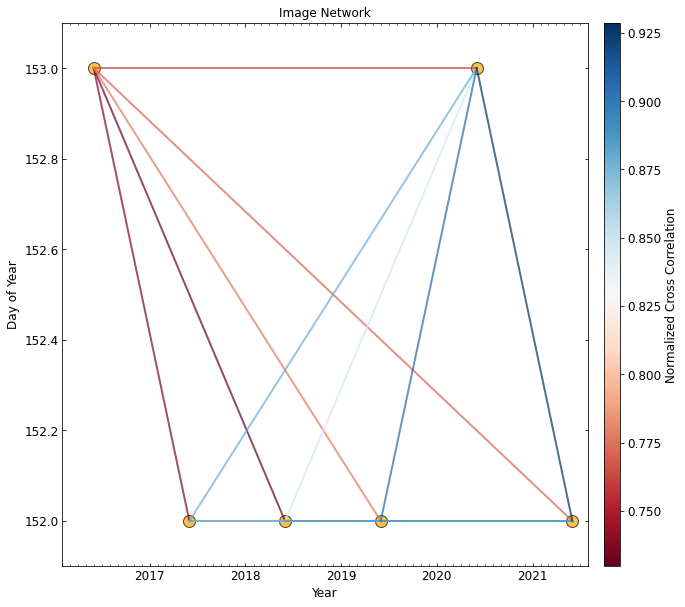

In [23]:
dates = pd.Series(pairs.date1.append(pairs.date2).unique())
dates_txt = dates.dt.strftime('%Y%m%d')
doy = dates.dt.dayofyear

p_dict = {}
p_dict['cohList'] = pairs.ncc.tolist()
p_dict['vlim'] = [pairs.ncc.min(),pairs.ncc.max()]
p_dict['xlabel'] = 'Year'
p_dict['ylabel'] = 'Day of Year'
p_dict['cbar_label'] = 'Normalized Cross Correlation'

f, ax = plt.subplots(1,1,figsize=(10,10))
ax = plot.plot_network(ax,pairs.date12.tolist(),dates_txt,doy,p_dict)
ax.set_title('Image Network')
print(f'{pairs.shape[0]} pairs for {dates.shape[0]} dates')

## Best of year selection

In [78]:
test = means.to_frame().reset_index().rename(columns={'index':'date',0:'ncc'})
test['year'] = test.date.str[0:4]

best = test.groupby('year').max('ncc')

keep = test.loc[test.groupby('year').ncc.idxmax(),'date']

pairs = df_long[(df_long['date1'].isin(keep)) & (df_long['date2'].isin(keep))].copy()

pairs['date12'] = pairs['date1'] + '-' + pairs['date2']
pairs['date1'] = pd.to_datetime(pairs.date1)
pairs['date2'] = pd.to_datetime(pairs.date2)

pairs['image1'] = [names[x] for x in pairs.date1.dt.strftime('%Y%m%d')]
pairs['image2'] = [names[x] for x in pairs.date2.dt.strftime('%Y%m%d')]

pairs[['image1','image2']].to_csv('pairs_yearly.csv',index=False)

max perpendicular baseline: 277.00 m
max temporal      baseline: 1550.0 days
showing coherence
data range: [0.582173648620408, 0.8397704009648479]
display range: [0.582173648620408, 0.8397704009648479]
15 pairs for 6 dates


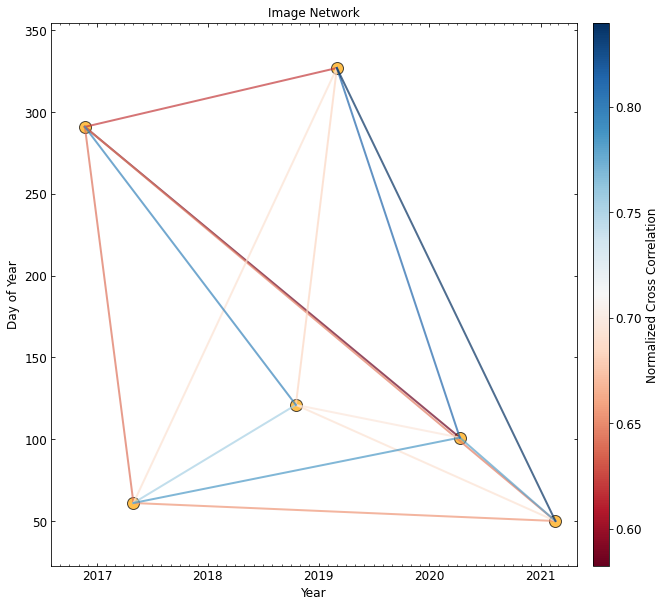

In [79]:
dates = pd.Series(pairs.date1.append(pairs.date2).unique())
dates_txt = dates.dt.strftime('%Y%m%d')
doy = dates.dt.dayofyear

p_dict = {}
p_dict['cohList'] = pairs.ncc.tolist()
p_dict['vlim'] = [pairs.ncc.min(),pairs.ncc.max()]
p_dict['xlabel'] = 'Year'
p_dict['ylabel'] = 'Day of Year'
p_dict['cbar_label'] = 'Normalized Cross Correlation'

f, ax = plt.subplots(1,1,figsize=(10,10))
ax = plot.plot_network(ax,pairs.date12.tolist(),dates_txt,doy,p_dict)
ax.set_title('Image Network')
print(f'{pairs.shape[0]} pairs for {dates.shape[0]} dates')